# **Práctica Deep Learning – Predicción de Engagement en POIs Turísticos**
*KeepCoding – Junio 2025*

Este cuaderno implementa de forma **completa y reproducible** el flujo de trabajo solicitado en la práctica:

1. Preparación y análisis de datos
2. Diseño de modelo multimodal (imágenes + metadatos)
3. Entrenamiento y optimización
4. Evaluación, interpretación y guardado del modelo



In [ ]:

# Sólo descomenta y ejecuta si estés en Colab. Si no, déjalo tal cual.

#from google.colab import drive
#import os

#drive.mount('/content/drive')
#project_path = '/content/drive/MyDrive/Practica_Deep_Learning_Keepcoding'
#os.chdir(project_path)
#print("Montado Google Drive y cambiado al directorio del proyecto.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Montado Google Drive y cambiado al directorio del proyecto.


In [2]:
!pip install -r requirements.txt

#Importación de librerías y scripts
import ast
import cv2
import torch
import optuna
import folium
import random
import numpy as np
import pandas as pd
import seaborn as sns
import optuna.visualization
import shutil
import pickle
import matplotlib.pyplot as plt
from tensorboard import program
from torchvision import transforms
from torchvision import models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from collections import Counter
from PIL import Image
from module_utils import *

In [3]:
# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)

Usando dispositivo: cuda


## **1. Preparación y Análisis de los Datos**


### 1.1 Carga de los datos

In [4]:
# Cargar el dataset
df = pd.read_csv("poi_dataset.csv")

# Mostrar las primeras filas del dataset
df.head()

,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


### 1.2 Análisis exploratorio

In [5]:
# Tamaño del dataset
print(f"Dimensiones del dataset: {df.shape}")

# Información general del dataset
print(f"Información general del dataset:")
df.info()

Dimensiones del dataset: (1569, 14)
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


In [6]:
# Eliminamos las columnas: id, name, shortDescription
df.drop(columns=['id', 'name', 'shortDescription'], inplace=True)
df.columns

Index(['categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps',
       'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path'],
      dtype='object')

In [7]:
# Estadística descriptiva de las variables numéricas
print("\nEstadística descriptiva de todas las variables numéricas:")
print(df.describe())


Estadística descriptiva de todas las variables numéricas:
              tier  locationLon  locationLat          xps        Visits  \
count  1569.000000  1569.000000  1569.000000  1569.000000   1569.000000   
mean      1.541109    -1.132337    39.900141   750.382409  10011.943276   
std       0.637677    22.733401     9.662134   228.319854      5.456808   
min       1.000000  -121.951049   -62.940930     0.000000  10001.000000   
25%       1.000000    -3.725292    40.411754   600.000000  10008.000000   
50%       1.000000    -3.699140    40.421738   700.000000  10011.000000   
75%       2.000000    -3.673348    40.472458  1000.000000  10015.000000   
max       4.000000   158.333118    65.706572  1000.000000  10038.000000   

              Likes      Dislikes    Bookmarks  
count   1569.000000   1569.000000  1569.000000  
mean    3623.908222   2526.305927   973.261950  
std     4817.879374   2225.543360  1453.333948  
min      100.000000     52.000000    50.000000  
25%      464.000000 

### Análisis de variables categóricas

In [8]:
df["categories"][0]

"['Escultura', 'Pintura']"

In [9]:
type(df["categories"][0])

str

In [10]:
type(df["tags"][0])

str

In [11]:
# Convertir strings con formato de lista a listas reales
df["categories"] = df["categories"].apply(ast.literal_eval)
df["tags"] = df["tags"].apply(ast.literal_eval)

print(type(df["categories"][0]))
print(type(df["tags"][0]))

<class 'list'>
<class 'list'>


In [12]:
# Aplanamos y contamos valores únicos de 'categories'
num_unique_cat = df['categories'].explode().nunique()
print(f"Número de categorías únicas: {num_unique_cat}")

Número de categorías únicas: 12


categories
0       2
1      63
2     106
3    1073
4     325
Name: count, dtype: int64


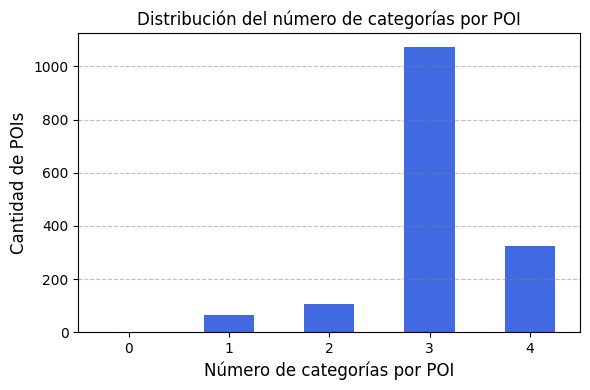

In [13]:
# Contar el número de categorías por POI
num_categories = df['categories'].apply(len)
print(num_categories.value_counts().sort_index())

# Historama
plt.figure(figsize=(6, 4))
num_categories.value_counts().sort_index().plot(kind='bar', color='#4169E1')
plt.xlabel('Número de categorías por POI', fontsize=12)
plt.ylabel('Cantidad de POIs', fontsize=12)
plt.title('Distribución del número de categorías por POI')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

In [14]:
# Aplanamos y contamos valores únicos de 'tags'
num_unique_tag = df['tags'].explode().nunique()
print(f"Número de etiquetas únicas: {num_unique_tag}")

Número de etiquetas únicas: 2935


tags
0     107
1     136
2      24
3      56
4     102
5      58
6      33
7      10
8       8
9       2
10    473
11      6
12     88
13    466
Name: count, dtype: int64


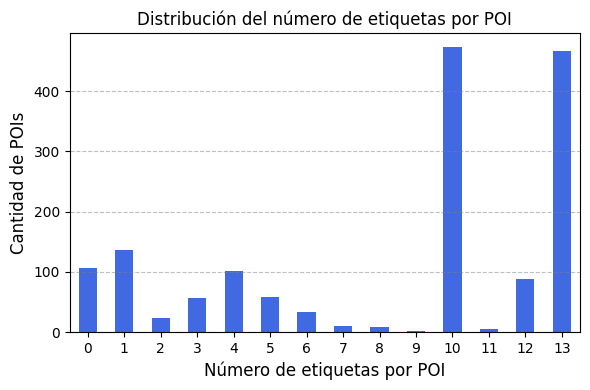

In [15]:
# Contar el número de 'tags' por POI
num_tag = df['tags'].apply(len)
print(num_tag.value_counts().sort_index())

# Historama
plt.figure(figsize=(6, 4))
num_tag.value_counts().sort_index().plot(kind='bar', color='#4169E1')
plt.xlabel('Número de etiquetas por POI', fontsize=12)
plt.ylabel('Cantidad de POIs', fontsize=12)
plt.title('Distribución del número de etiquetas por POI')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

In [16]:
# Contar la frecuencia de cada tag
tag_freq = df['tags'].explode().value_counts()

# Top 10 más frecuentes
top10_tags = tag_freq.head(10).index.tolist()
print("Top 10 tags más frecuentes:", top10_tags)
print(tag_freq.head(10))

Top 10 tags más frecuentes: ['Historia', 'Madrid', 'Cultura', 'Arquitectura', 'Patrimonio', 'Arte', 'Escultura', 'Estatua', 'Monumento', 'Naturaleza']
tags
Historia        802
Madrid          700
Cultura         583
Arquitectura    398
Patrimonio      353
Arte            329
Escultura       328
Estatua         269
Monumento       166
Naturaleza      150
Name: count, dtype: int64


### Análisis de variables numéricas

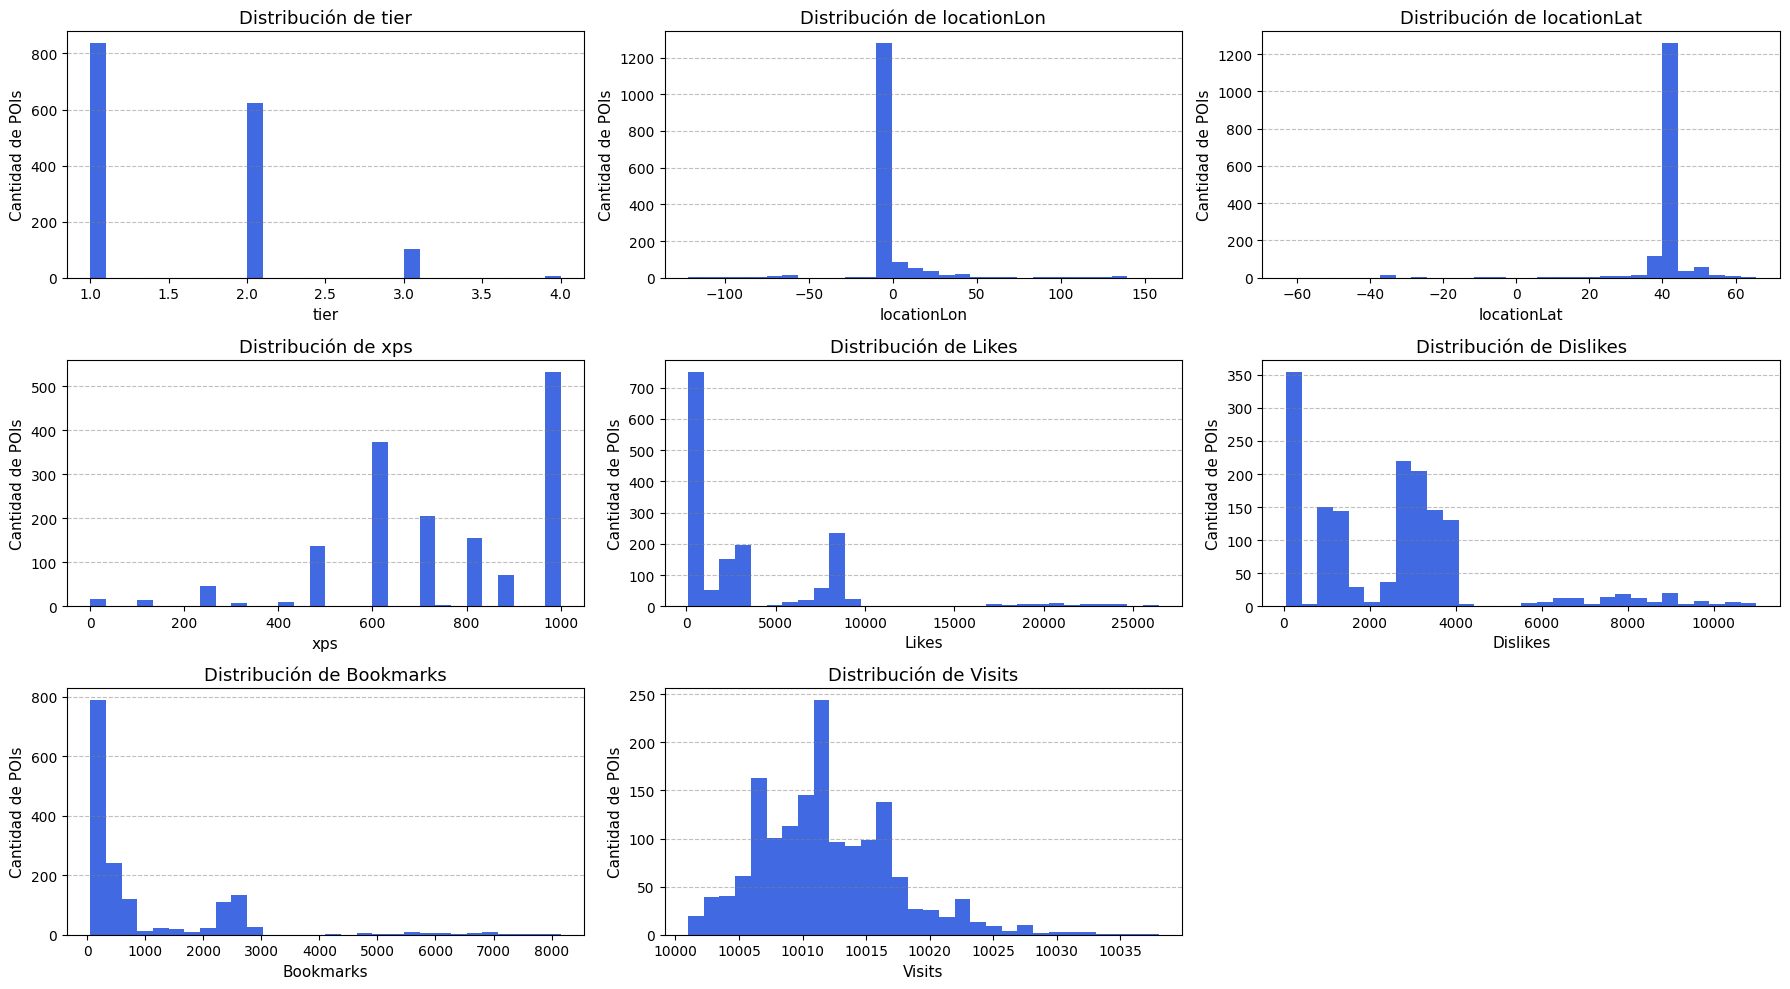

In [17]:
# Histograma de las variables numéricas
# Seleccionar columnas numéricas
numeric_cols = ['tier', 'locationLon', 'locationLat', 'xps', 'Likes', 'Dislikes', 'Bookmarks', 'Visits']

# Crear figura
plt.figure(figsize=(18, 10))

# Generar subplots de 3 columnas por fila
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col].dropna(), bins=30, color='#4169E1')

    plt.xlabel(col, fontsize=11)
    plt.ylabel('Cantidad de POIs', fontsize=11)
    plt.title(f'Distribución de {col}', fontsize=13)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')

plt.tight_layout()
plt.show()

In [18]:
# Contar valores únicos que tiene la variable 'xps'
# Mostrar la distribución de frecuencias de cada valor de 'xps'
val_unicos_xps = df['xps'].nunique()
print(f"Número de valores únicos en xps: {val_unicos_xps}")
print(df['xps'].value_counts().sort_index())

Número de valores únicos en xps: 13
xps
0        16
100      13
150       1
250      46
300       7
400      10
500     137
600     372
700     206
750       2
800     155
900      71
1000    533
Name: count, dtype: int64


In [19]:
# Contar valores únicos que tiene la variable 'tier'
# Mostrar la distribución de frecuencias de cada valor de 'tier'
val_unicos_tier = df['tier'].nunique()
print(f"Número de valores únicos en tier: {val_unicos_tier}")
print(df['tier'].value_counts().sort_index())

Número de valores únicos en tier: 4
tier
1    837
2    622
3    103
4      7
Name: count, dtype: int64


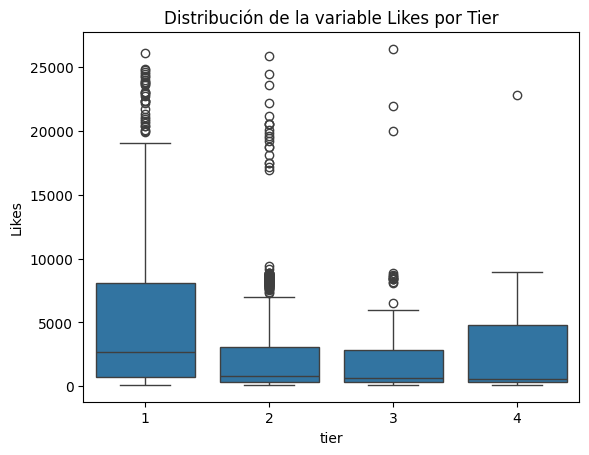

In [20]:
# Boxplot variables 'Likes' por 'tier
sns.boxplot(x=df['tier'], y=df['Likes'])
plt.title("Distribución de la variable Likes por Tier")
plt.show()

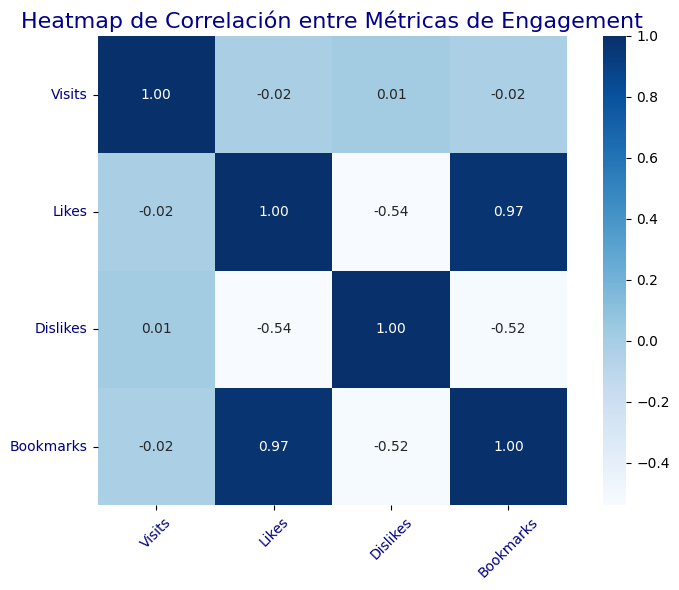

In [21]:
# Heatmap correlación de las métricas de engagement
engagement_cols = ['Visits', 'Likes', 'Dislikes', 'Bookmarks']

# Calcular la matriz de correlación
corr_matrix = df[engagement_cols].corr()

# Heatmap con degradado en tonos de azul
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
plt.title('Heatmap de Correlación entre Métricas de Engagement', fontsize=16, color='darkblue')
plt.xticks(rotation=45, color='navy')
plt.yticks(rotation=0, color='navy')
plt.tight_layout()
plt.show()

### 1.3 Codificación variables categóricas

In [22]:
# Codificar la variable 'categories' con MultiLabelBinarizer
mlb = MultiLabelBinarizer()
df_mlb = pd.DataFrame(mlb.fit_transform(df["categories"]), columns=mlb.classes_)
df_mlb.head()

,Arquitectura,Ciencia,Cine,Cultura,Escultura,Gastronomía,Historia,Misterio,Naturaleza,Ocio,Patrimonio,Pintura
0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0


In [23]:
# Juntamos el one-hot con el dataframe original
df = pd.concat([df, df_mlb], axis=1)
df.head()


,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,...,Cine,Cultura,Escultura,Gastronomía,Historia,Misterio,Naturaleza,Ocio,Patrimonio,Pintura
0,"[Escultura, Pintura]",1,2.642262,39.572694,[],500,10009,422,3582,78,...,0,0,1,0,0,0,0,0,0,1
1,"[Patrimonio, Historia]",1,-3.704467,40.423037,[],500,10010,7743,96,2786,...,0,0,0,0,1,0,0,0,1,0
2,"[Ciencia, Patrimonio]",2,-3.699694,40.442045,[],250,10015,3154,874,595,...,0,0,0,0,0,0,0,0,1,0
3,[Cultura],1,-3.691228,40.427256,[],500,10011,8559,79,2358,...,0,1,0,0,0,0,0,0,0,0
4,"[Patrimonio, Cultura]",1,-3.727822,40.439665,[],500,10020,915,2896,143,...,0,1,0,0,0,0,0,0,1,0


In [24]:
# Eliminamos la columna 'categories' del dataset
df.drop(columns=['categories'], inplace=True)

In [25]:
# Crear columnas multi-hot para cada tag del Top10
for tag in top10_tags:
    df[f'tag_{tag}'] = df['tags'].apply(lambda lst: int(tag in lst))

# Añadimos columna 'tag_other' para cualquier tag que no se encunetre en el top 10
df['tag_other'] = df['tags'].apply(lambda lst: int(any(t not in top10_tags for t in lst)))

# Eliminamos la columna 'tags' del dataset
df.drop(columns=['tags'], inplace=True)

df.head()

,tier,locationLon,locationLat,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path,Arquitectura,...,tag_Madrid,tag_Cultura,tag_Arquitectura,tag_Patrimonio,tag_Arte,tag_Escultura,tag_Estatua,tag_Monumento,tag_Naturaleza,tag_other
0,1,2.642262,39.572694,500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...,0,...,0,0,0,0,0,0,0,0,0,0
1,1,-3.704467,40.423037,500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-3.699694,40.442045,250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...,0,...,0,0,0,0,0,0,0,0,0,0
3,1,-3.691228,40.427256,500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...,0,...,0,0,0,0,0,0,0,0,0,0
4,1,-3.727822,40.439665,500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 Creación de la variable target

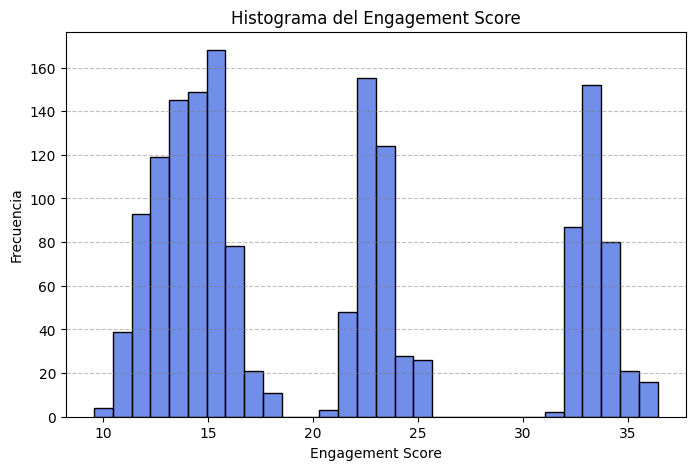

In [26]:
# Crear la variable engagement_score
# Pasamos a escala logarítmica las variables del engagement
df['log_visits']    = np.log1p(df['Visits'])
df['log_likes']     = np.log1p(df['Likes'])
df['log_dislikes']  = np.log1p(df['Dislikes'])
df['log_bookmarks'] = np.log1p(df['Bookmarks'])

# Calculamos el engagement_score como suma ponderada de cada variable
df['engagement_score'] = (1.0  * df['log_visits'] + 1.5 * df['log_likes'] + 2.5 * df['log_bookmarks'] - 2.0 * df['log_dislikes'])

# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(df['engagement_score'], bins=30, color='#4169E1')
plt.title('Histograma del Engagement Score')
plt.xlabel('Engagement Score')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.show()

In [27]:
# Estadística de la variable 'engagement_score'
print(df["engagement_score"].describe())

count    1569.000000
mean       20.682256
std         7.999699
min         9.578371
25%        14.005216
50%        16.425519
75%        24.566047
max        36.419854
Name: engagement_score, dtype: float64


In [28]:
bins = [-np.inf, 19, 30, np.inf]
labels = [0, 1, 2]  # 0 = bajo, 1 = medio, 2 = alto

df['engagement_level'] = pd.cut(df['engagement_score'], bins=bins, labels=labels).astype(int)

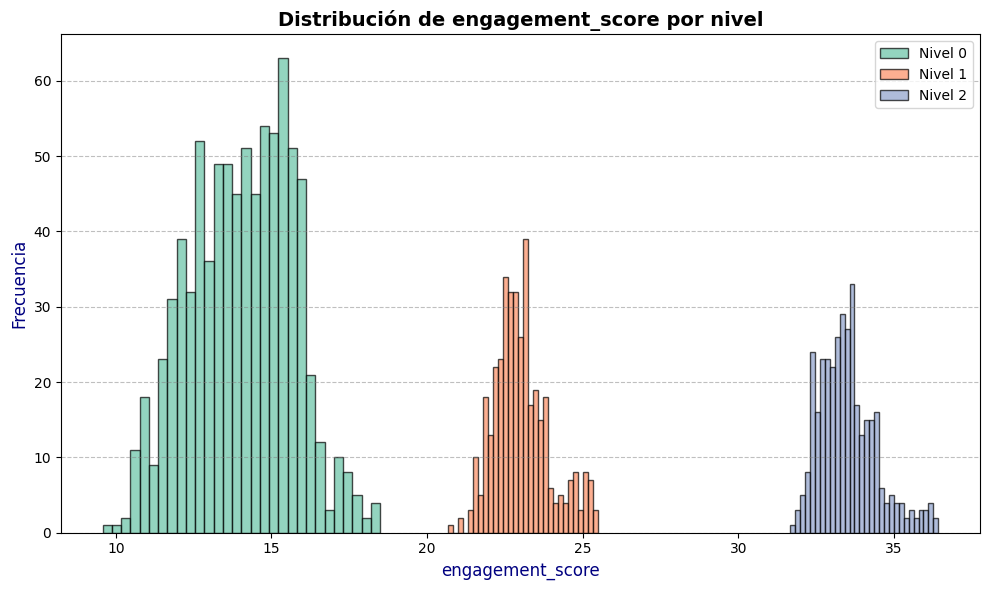

In [29]:
# Histograma coloreado por niveles de engagement
plt.figure(figsize=(10, 6))
labels = [0, 1, 2]
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

for i, label in enumerate(labels):
    subset = df[df["engagement_level"] == label]
    plt.hist(subset["engagement_score"], bins=30, alpha=0.7, color=colors[i], label=f'Nivel {label}', edgecolor='black')

plt.title("Distribución de engagement_score por nivel", fontsize=14, fontweight='bold', color='black')
plt.xlabel("engagement_score", fontsize=12, color='navy')
plt.ylabel("Frecuencia", fontsize=12, color='navy')
plt.legend()
plt.grid(axis='y', alpha=0.5, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

In [30]:
# Eliminamos la columna 'engagement_score', "Visits", "Likes", "Dislikes" y "Bookmarks"
df.drop(columns=["engagement_score", "Visits", "Dislikes", "Likes", "Bookmarks"], inplace=True)

In [31]:
# Contar la frecuencia de cada nivel de engagement
print("Distribución de engagement_level:")
print(df['engagement_level'].value_counts())

Distribución de engagement_level:
engagement_level
0    827
1    384
2    358
Name: count, dtype: int64


In [32]:
# Vemos la estructura final del Dataframe
print(df.dtypes)
print(df.shape)
df.head()

tier                  int64
locationLon         float64
locationLat         float64
xps                   int64
main_image_path      object
Arquitectura          int64
Ciencia               int64
Cine                  int64
Cultura               int64
Escultura             int64
Gastronomía           int64
Historia              int64
Misterio              int64
Naturaleza            int64
Ocio                  int64
Patrimonio            int64
Pintura               int64
tag_Historia          int64
tag_Madrid            int64
tag_Cultura           int64
tag_Arquitectura      int64
tag_Patrimonio        int64
tag_Arte              int64
tag_Escultura         int64
tag_Estatua           int64
tag_Monumento         int64
tag_Naturaleza        int64
tag_other             int64
log_visits          float64
log_likes           float64
log_dislikes        float64
log_bookmarks       float64
engagement_level      int64
dtype: object
(1569, 33)


,tier,locationLon,locationLat,xps,main_image_path,Arquitectura,Ciencia,Cine,Cultura,Escultura,...,tag_Escultura,tag_Estatua,tag_Monumento,tag_Naturaleza,tag_other,log_visits,log_likes,log_dislikes,log_bookmarks,engagement_level
0,1,2.642262,39.572694,500,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...,0,0,0,0,1,...,0,0,0,0,0,9.211340,6.047372,8.183956,4.369448,0
1,1,-3.704467,40.423037,500,data_main/e32b3603-a94f-49df-8b31-92445a86377c...,0,0,0,0,0,...,0,0,0,0,0,9.211440,8.954674,4.574711,7.932721,2
2,2,-3.699694,40.442045,250,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...,0,1,0,0,0,...,0,0,0,0,0,9.211939,8.056744,6.774224,6.390241,1
3,1,-3.691228,40.427256,500,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...,0,0,0,1,0,...,0,0,0,0,0,9.211540,9.054855,4.382027,7.765993,2
4,1,-3.727822,40.439665,500,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...,0,0,0,1,0,...,0,0,0,0,0,9.212438,6.820016,7.971431,4.969813,0


### 1.5 Exploración de las imágenes

In [33]:
# Mostrar las primeras rutas de las imágenes
print(df['main_image_path'].head())

0    data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1    data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2    data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3    data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4    data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...
Name: main_image_path, dtype: object


In [ ]:
# Contar las formas de las imágenes
# Extraer rutas desde el DataFrame
image_paths = df['main_image_path'].dropna().tolist()

# Contador de tamaños
size_counter = Counter()

# Iterar por cada imagen y registrar su tamaño
for img_path in tqdm(image_paths, desc="Contando tamaños de imagen"):
    try:
        with Image.open(img_path) as img:
            size_counter[img.size] += 1
    except Exception as e:
        print(f"Error con {img_path}: {e}")

# Mostrar los tamaños más frecuentes
for size, count in size_counter.most_common(10):
    print(f"Tamaño {size}: {count} imágenes")


Contando tamaños de imagen:   9%|▉         | 138/1569 [00:02<00:23, 61.22it/s] 


KeyboardInterrupt: 

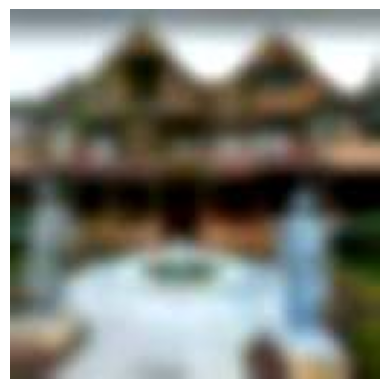

In [34]:
# Mostrar una imagen aleatoria del dataset
random_image_path = random.choice(df['main_image_path'])
random_image = Image.open(random_image_path)
plt.imshow(random_image)
plt.axis('off')
plt.show()


In [34]:
# Transforms con data augmentation (para train)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Redimensionar  para ResNet
    transforms.RandomRotation(degrees=10),            # Rotación de la imagen
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Corrección de color
    transforms.ToTensor(),                            # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalización para ResNet
                         std=[0.229, 0.224, 0.225])
])

# Transforms sin data augmentación (para validation y test)
val_test_transform  = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### 1.7 Creación Dataset personalizado y división de los datos





In [35]:

class POIDataset(Dataset):
    '''Clase para manejar el dataset de POIs y pasarlo a un DataLoader de PyTorch.

     Atributos:
        target (Tensor): vector de etiquetas (clases 0, 1, 2).
        image_paths (array): rutas de las imágenes.
        features (Tensor): variables de entrada normalizadas (incluyendo tier si no se embebe).
        transform: transformaciones de las imágenes (augmentación, redimensionado, normalización).

    Métodos:
        __len__(): devuelve el número de muestras.
        __getitem__(idx): devuelve una tupla con (imagen transformada, etiqueta, features)
    '''

    def __init__(self, target, image_paths, features, transform=None):
        assert len(target) == len(features) == len(image_paths)
        self.target = torch.tensor(target, dtype=torch.long)
        self.image_paths = image_paths
        self.features = torch.tensor(features, dtype=torch.float)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        with Image.open(image_path).convert('RGB') as img:
            image = self.transform(img)

        target = self.target[idx]
        features = self.features[idx]

        return image, target, features


In [36]:
# División de los datos
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['engagement_level'], random_state=SEED)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, stratify=train_val_df['engagement_level'], random_state=SEED)

# Normalización
cols_to_scale = ['xps', 'locationLat', 'locationLon']
scaler = StandardScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
val_df[cols_to_scale] = scaler.transform(val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

# Selección de features
excluded_cols = ['engagement_level', 'main_image_path', 'log_visits', 'log_likes', 'log_dislikes', 'log_bookmarks']
feature_cols = train_df.drop(columns=excluded_cols).columns.tolist()

# Preparación de los datos
X_train = train_df[feature_cols].values
y_train = train_df['engagement_level'].values
img_paths_train = train_df['main_image_path'].values

X_val = val_df[feature_cols].values
y_val = val_df['engagement_level'].values
img_paths_val = val_df['main_image_path'].values

X_test = test_df[feature_cols].values
y_test = test_df['engagement_level'].values
img_paths_test = test_df['main_image_path'].values

In [37]:
# Crear los Datasets
train_dataset = POIDataset(y_train, img_paths_train, X_train, transform=train_transform)
val_dataset   = POIDataset(y_val, img_paths_val, X_val, transform=val_test_transform)
test_dataset  = POIDataset(y_test, img_paths_test, X_test, transform=val_test_transform)

# Tamaños de los Datasets
print("Tamaño de Train:", X_train.shape)
print("Tamaño de Val:", X_val.shape)
print("Tamaño de Test:", X_test.shape)

Tamaño de Train: (1133, 27)
Tamaño de Val: (200, 27)
Tamaño de Test: (236, 27)


In [38]:
# Recuento de las etiquetas en cada conjunto
train_counts = pd.Series(y_train).value_counts(normalize=True).sort_index()
val_counts   = pd.Series(y_val).value_counts(normalize=True).sort_index()
test_counts  = pd.Series(y_test).value_counts(normalize=True).sort_index()

sample = train_dataset[0]
print("Imagen:", sample[0].shape)
print("Etiqueta:", sample[1])
print("Features:", sample[2].shape)

print("Distribución etiquetas en Train: ", train_counts.to_dict())
print("Distribución etiquetas en Val: ", val_counts.to_dict())
print("Distribución etiquetas en Test: ", test_counts.to_dict())

Imagen: torch.Size([3, 224, 224])
Etiqueta: tensor(2)
Features: torch.Size([27])
Distribución etiquetas en Train:  {0: 0.527802294792586, 1: 0.2444836716681377, 2: 0.22771403353927624}
Distribución etiquetas en Val:  {0: 0.525, 1: 0.245, 2: 0.23}
Distribución etiquetas en Test:  {0: 0.5254237288135594, 1: 0.2457627118644068, 2: 0.2288135593220339}


In [39]:
# Crear los DataLoaders
g = torch.Generator()
g.manual_seed(SEED)
BATCH_SIZE = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=g,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    generator=g,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    generator=g,
    num_workers=0,
    pin_memory=True,
)

# Calculamos las iteraciones por epoch
total_batch = len(train_loader)
print(f"Total de batches por epoch: {total_batch}")

Total de batches por epoch: 5


## **2. Arquitectura del Modelo**

In [40]:
class POIMultimodalModel(nn.Module):
    def __init__(self, metadata_dim, hidden_dim=128, dropout_rate=0.4, activation_fn=nn.ELU):
        super(POIMultimodalModel, self).__init__()

        self.activation_fn = activation_fn

        # Rama para imágenes (CNN preentrenada ResNet18)
        self.resnet = models.resnet18(pretrained=True)
        self.resnet_output_dim = self.resnet.fc.in_features  # 512 en ResNet18
        self.resnet.fc = nn.Identity()  # Eliminamos la capa final

        # Rama metadatos
        self.meta_branch = nn.Sequential(
            nn.Linear(metadata_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation_fn()
        )

        # Fusión y clasificador
        self.fusion_input_dim = self.resnet_output_dim + hidden_dim
        self.fusion_branch = nn.Sequential(
            nn.Linear(self.fusion_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 3)  # 3 clases
        )

    def forward(self, image, metadata):
        # Extraer features de la imagen
        image_features = self.resnet(image)

        # Procesar metadatos
        x_meta = self.meta_branch(metadata)

        # Fusión y salida
        fusion_input = torch.cat([image_features, x_meta], dim=1)
        output = self.fusion_branch(fusion_input)

        return output

In [45]:
# Creamos una isntancia al modelo, la guardamos en la variable 'model',
# y la movemos al dispositivo(cuda o cpu)
model = POIMultimodalModel(
    metadata_dim=X_train.shape[1],
    hidden_dim=128,
    dropout_rate=0.4,
    activation_fn=nn.ELU
).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
# Cargar un batch y probar el modelo
images, labels, metadata = next(iter(train_loader))

# Mover datos al mismo dispositivo que el modelo
images = images.to(device)
metadata = metadata.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images, metadata)

print("Output shape:", outputs.shape)

Output shape: torch.Size([256, 3])


## **3. Entrenamiento y Optimización**

In [46]:
# 'class_weights' para balancear las clases
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# Función de pérdida ponderada
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [47]:
# Función para entrenamiento y validación del modelo
def POI_train_model(model, train_loader, val_loader, criterion,
                    weight_decay, learning_rate, num_epochs, early_stopping,
                    scheduler=None):

    print(f"[INFO]: Usando dispositivo: {device}")
    print(f"[INFO]: Learning rate: {learning_rate}")
    print(f"[INFO]: Número de epochs: {num_epochs}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler StepLR (reduce LR cada 3 epochs)
    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    lrs = []

    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, _ = train_epoch(
            model=model,
            device=device,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer
        )

        val_loss, val_acc = eval_epoch(
            model=model,
            device=device,
            val_loader=val_loader,
            criterion=criterion
        )

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping:
            break

    best_epoch = int(np.argmax(val_accs)) + 1
    print(f"[INFO] Mejor época: {best_epoch}, Val Acc: {val_accs[best_epoch - 1]:.2f}%")

    plot_training_curves(train_losses, val_losses, train_accs, val_accs)
    plot_learning_rate(lrs)

    return model, (train_losses, val_losses, train_accs, val_accs), best_model_state, best_val_acc


[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.001
[INFO]: Número de epochs: 10
[Epoch 1] Train Loss: 0.7562 Acc: 61.52% | Val Loss: 0.6653 Acc: 78.50%
[Epoch 2] Train Loss: 0.4358 Acc: 83.85% | Val Loss: 0.6542 Acc: 78.00%
[Epoch 3] Train Loss: 0.3337 Acc: 86.67% | Val Loss: 0.7369 Acc: 79.00%
[Epoch 4] Train Loss: 0.2392 Acc: 92.50% | Val Loss: 1.2691 Acc: 69.00%
[Epoch 5] Train Loss: 0.1951 Acc: 94.09% | Val Loss: 1.4967 Acc: 63.00%
[Epoch 6] Train Loss: 0.1653 Acc: 94.53% | Val Loss: 0.8508 Acc: 71.00%
[INFO] Mejor época: 3, Val Acc: 79.00%


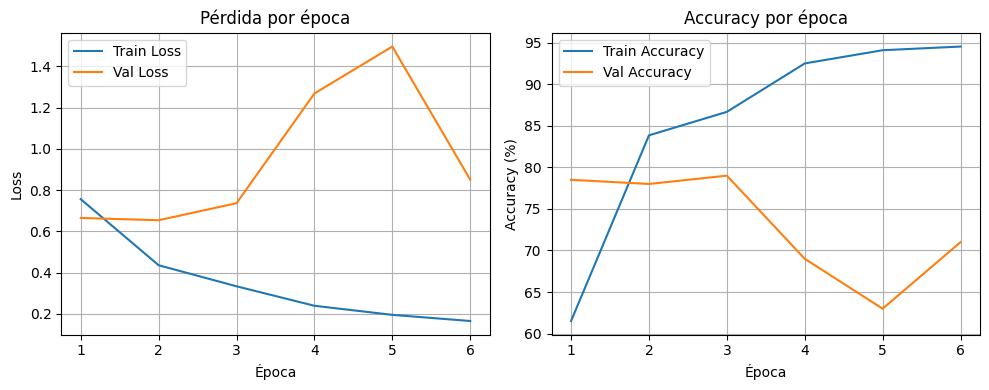

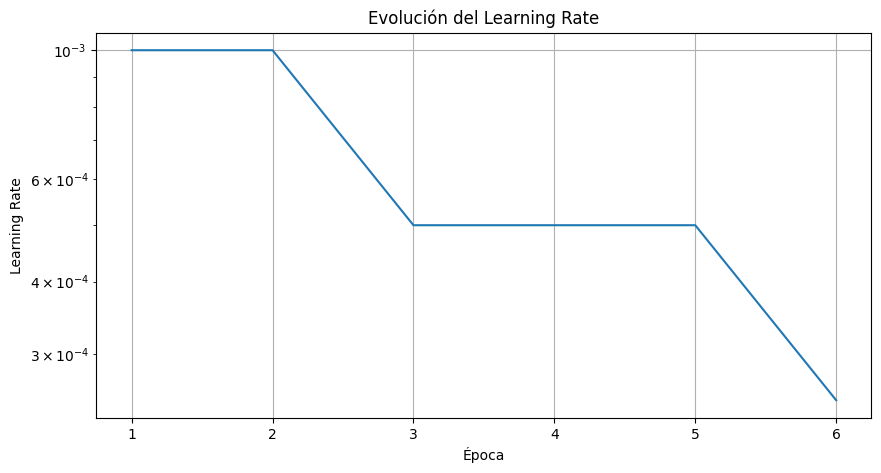

In [45]:
# Entrenamiento 1 (con dropout_rate=0.3, ReLu y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 1e-3
weight_decay = 1e-3
num_epochs = 10
early_stopping = 3

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.0005
[INFO]: Número de epochs: 10
[Epoch 1] Train Loss: 0.7888 Acc: 64.78% | Val Loss: 0.7981 Acc: 68.50%
[Epoch 2] Train Loss: 0.4051 Acc: 82.44% | Val Loss: 0.6081 Acc: 80.00%
[Epoch 3] Train Loss: 0.3163 Acc: 88.17% | Val Loss: 0.9258 Acc: 76.00%
[Epoch 4] Train Loss: 0.2323 Acc: 92.23% | Val Loss: 0.5602 Acc: 81.00%
[Epoch 5] Train Loss: 0.1969 Acc: 94.00% | Val Loss: 0.5537 Acc: 82.00%
[Epoch 6] Train Loss: 0.1601 Acc: 95.94% | Val Loss: 0.4848 Acc: 82.00%
[Epoch 7] Train Loss: 0.1530 Acc: 96.38% | Val Loss: 0.4503 Acc: 81.00%
[Epoch 8] Train Loss: 0.1329 Acc: 96.65% | Val Loss: 0.4408 Acc: 80.50%
[Epoch 9] Train Loss: 0.1287 Acc: 96.82% | Val Loss: 0.4357 Acc: 82.00%
[Epoch 10] Train Loss: 0.1127 Acc: 97.00% | Val Loss: 0.4357 Acc: 83.00%
[INFO] Mejor época: 10, Val Acc: 83.00%


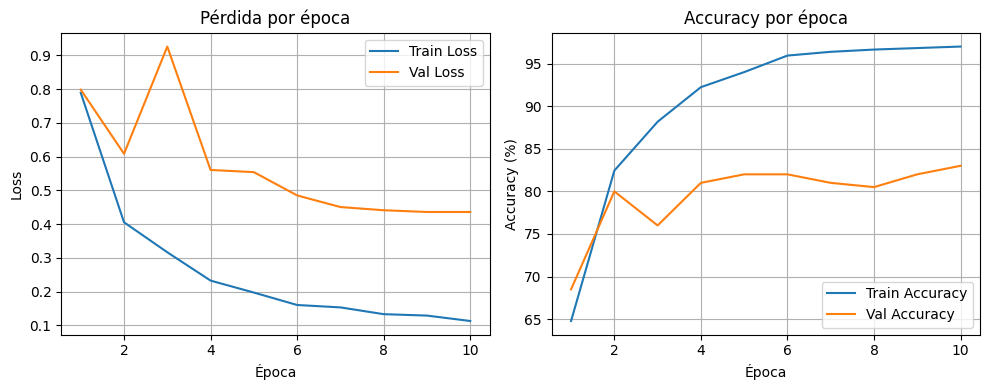

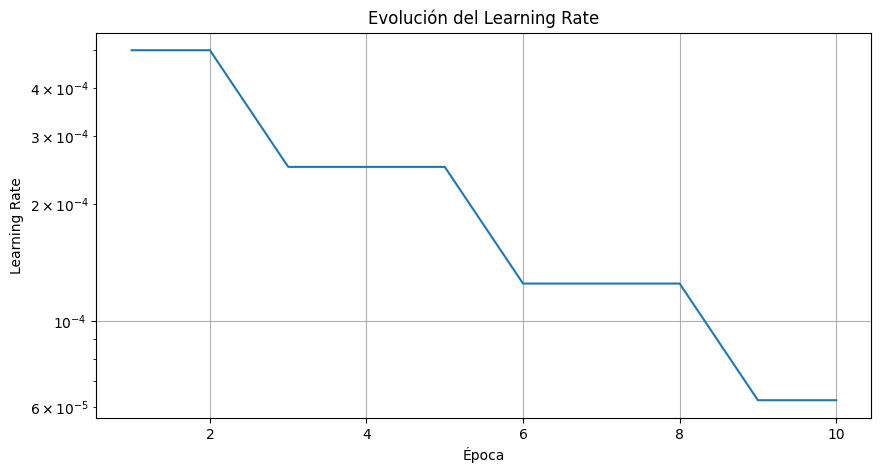

In [49]:
# Entrenamiento 2 (con dropout_rate=0.3, ReLu, y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 5e-4
weight_decay = 1e-3
num_epochs = 10
early_stopping = 5

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.0005
[INFO]: Número de epochs: 15
[Epoch 1] Train Loss: 0.7688 Acc: 62.67% | Val Loss: 0.6678 Acc: 78.50%
[Epoch 2] Train Loss: 0.4157 Acc: 83.14% | Val Loss: 0.5698 Acc: 81.50%
[Epoch 3] Train Loss: 0.3019 Acc: 89.14% | Val Loss: 0.5897 Acc: 80.50%
[Epoch 4] Train Loss: 0.2504 Acc: 90.20% | Val Loss: 0.4522 Acc: 85.50%
[Epoch 5] Train Loss: 0.1835 Acc: 94.97% | Val Loss: 0.7703 Acc: 74.00%
[Epoch 6] Train Loss: 0.1726 Acc: 95.50% | Val Loss: 0.4772 Acc: 83.50%
[Epoch 7] Train Loss: 0.1408 Acc: 96.73% | Val Loss: 0.4609 Acc: 84.50%
[Epoch 8] Train Loss: 0.1316 Acc: 97.62% | Val Loss: 0.4723 Acc: 84.50%
[Epoch 9] Train Loss: 0.1173 Acc: 97.18% | Val Loss: 0.4204 Acc: 85.00%
[INFO] Mejor época: 4, Val Acc: 85.50%


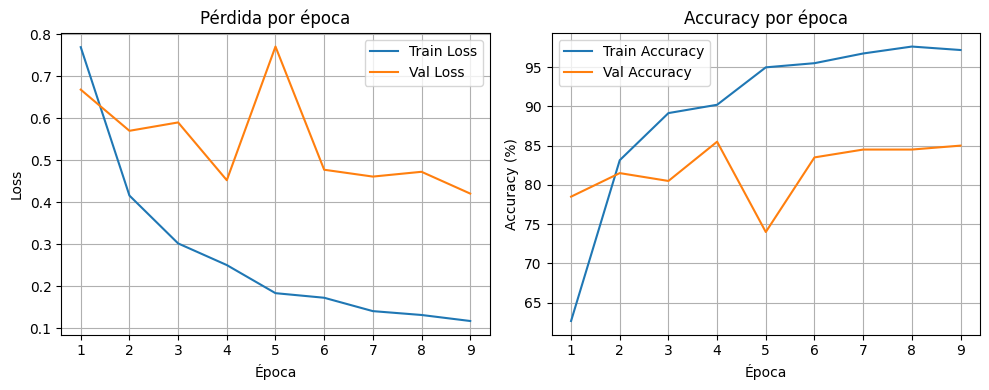

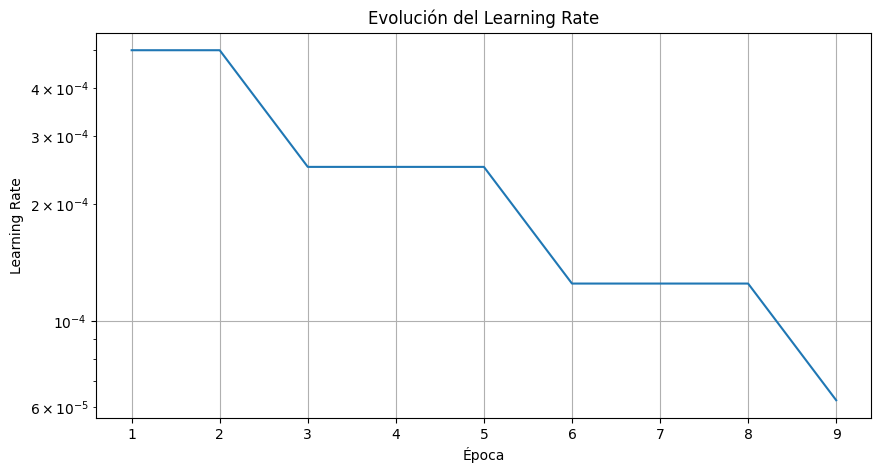

In [54]:
# Entrenamiento 3 (con dropout_rate=0.3, ReLu, y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 5e-4
weight_decay = 1e-3
num_epochs = 15
early_stopping = 5

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.0005
[INFO]: Número de epochs: 20
[Epoch 1] Train Loss: 0.8188 Acc: 58.08% | Val Loss: 0.7149 Acc: 75.50%
[Epoch 2] Train Loss: 0.4693 Acc: 83.67% | Val Loss: 0.4331 Acc: 86.00%
[Epoch 3] Train Loss: 0.3214 Acc: 88.97% | Val Loss: 0.7036 Acc: 80.50%
[Epoch 4] Train Loss: 0.2250 Acc: 92.94% | Val Loss: 0.4724 Acc: 85.50%
[Epoch 5] Train Loss: 0.1988 Acc: 93.56% | Val Loss: 0.4975 Acc: 83.50%
[Epoch 6] Train Loss: 0.1676 Acc: 95.50% | Val Loss: 0.5001 Acc: 83.00%
[Epoch 7] Train Loss: 0.1342 Acc: 97.18% | Val Loss: 0.4559 Acc: 84.00%
[INFO] Mejor época: 2, Val Acc: 86.00%


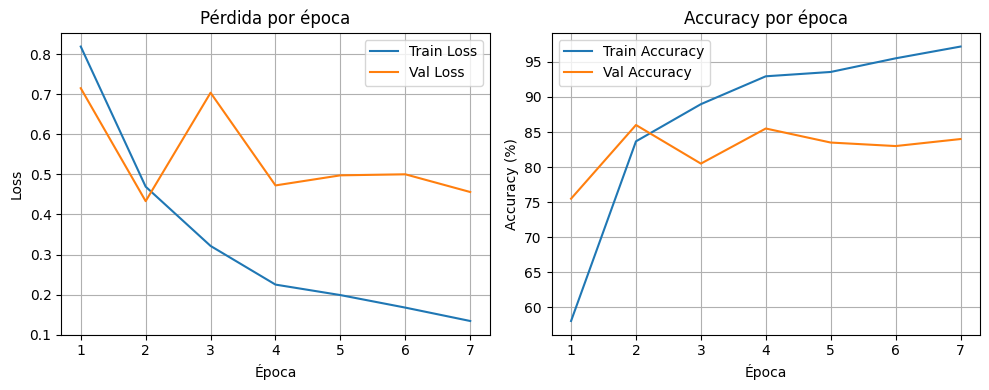

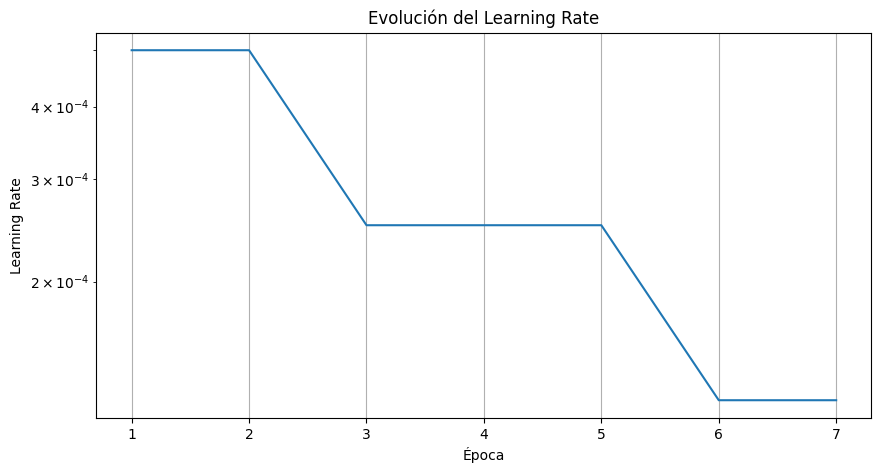

In [59]:
# Entrenamiento 4 (con dropout_rate=0.4, ReLu, y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 5e-4
weight_decay = 1e-3
num_epochs = 20
early_stopping = 5

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.0005
[INFO]: Número de epochs: 20
[Epoch 1] Train Loss: 0.7642 Acc: 60.81% | Val Loss: 0.8043 Acc: 75.00%
[Epoch 2] Train Loss: 0.4069 Acc: 81.82% | Val Loss: 0.7392 Acc: 80.50%
[Epoch 3] Train Loss: 0.2909 Acc: 89.67% | Val Loss: 0.5135 Acc: 85.00%
[Epoch 4] Train Loss: 0.2042 Acc: 93.03% | Val Loss: 0.3996 Acc: 87.50%
[Epoch 5] Train Loss: 0.1529 Acc: 95.23% | Val Loss: 0.4339 Acc: 85.50%
[Epoch 6] Train Loss: 0.1287 Acc: 96.20% | Val Loss: 0.4898 Acc: 86.00%
[Epoch 7] Train Loss: 0.1155 Acc: 96.73% | Val Loss: 0.4352 Acc: 87.00%
[Epoch 8] Train Loss: 0.0948 Acc: 97.00% | Val Loss: 0.4404 Acc: 86.50%
[Epoch 9] Train Loss: 0.0957 Acc: 97.53% | Val Loss: 0.4183 Acc: 86.00%
[INFO] Mejor época: 4, Val Acc: 87.50%


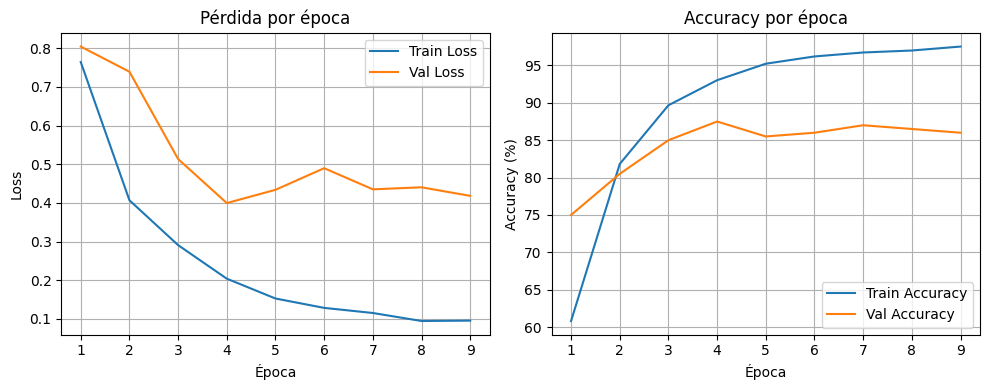

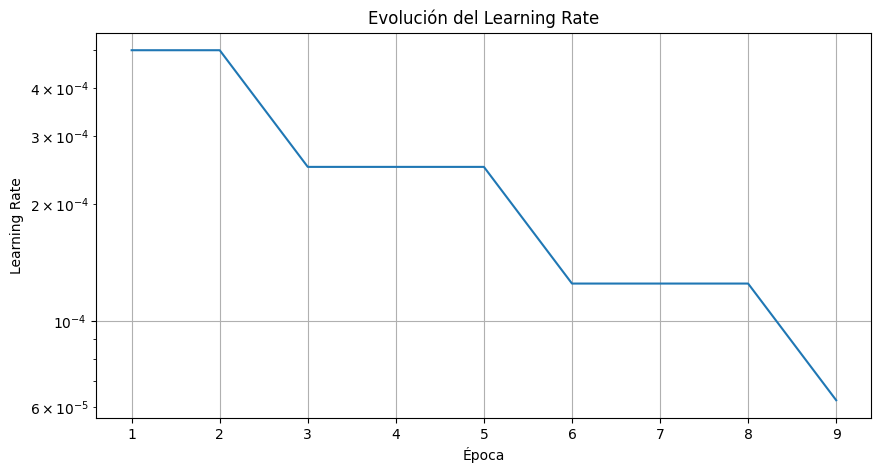

In [44]:
# Entrenamiento 5 (con dropout_rate=0.4, ELU, y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 5e-4
weight_decay = 1e-3
num_epochs = 20
early_stopping = 5

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

[INFO]: Usando dispositivo: cuda
[INFO]: Learning rate: 0.0005
[INFO]: Número de epochs: 20
[Epoch 1] Train Loss: 0.7747 Acc: 63.46% | Val Loss: 0.6201 Acc: 74.00%
[Epoch 2] Train Loss: 0.3745 Acc: 84.20% | Val Loss: 0.6129 Acc: 77.50%
[Epoch 3] Train Loss: 0.2487 Acc: 91.70% | Val Loss: 0.4633 Acc: 79.50%
[Epoch 4] Train Loss: 0.1774 Acc: 93.73% | Val Loss: 0.3940 Acc: 85.00%
[Epoch 5] Train Loss: 0.1460 Acc: 95.06% | Val Loss: 0.3715 Acc: 86.50%
[Epoch 6] Train Loss: 0.1184 Acc: 96.29% | Val Loss: 0.3427 Acc: 86.00%
[Epoch 7] Train Loss: 0.0936 Acc: 96.29% | Val Loss: 0.3224 Acc: 88.00%
[Epoch 8] Train Loss: 0.0930 Acc: 97.26% | Val Loss: 0.3472 Acc: 88.00%
[Epoch 9] Train Loss: 0.0863 Acc: 97.35% | Val Loss: 0.3594 Acc: 87.50%
[Epoch 10] Train Loss: 0.0805 Acc: 97.44% | Val Loss: 0.3654 Acc: 87.50%
[Epoch 11] Train Loss: 0.0839 Acc: 97.44% | Val Loss: 0.3636 Acc: 87.50%
[Epoch 12] Train Loss: 0.0731 Acc: 97.26% | Val Loss: 0.3607 Acc: 86.50%
[INFO] Mejor época: 7, Val Acc: 88.00%


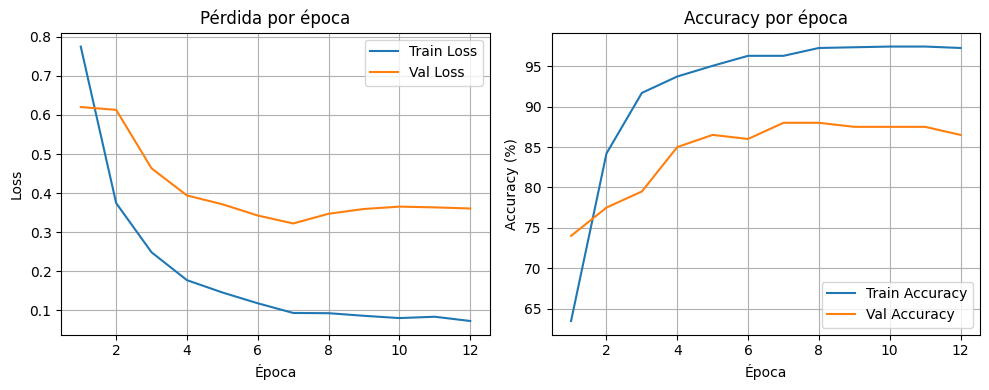

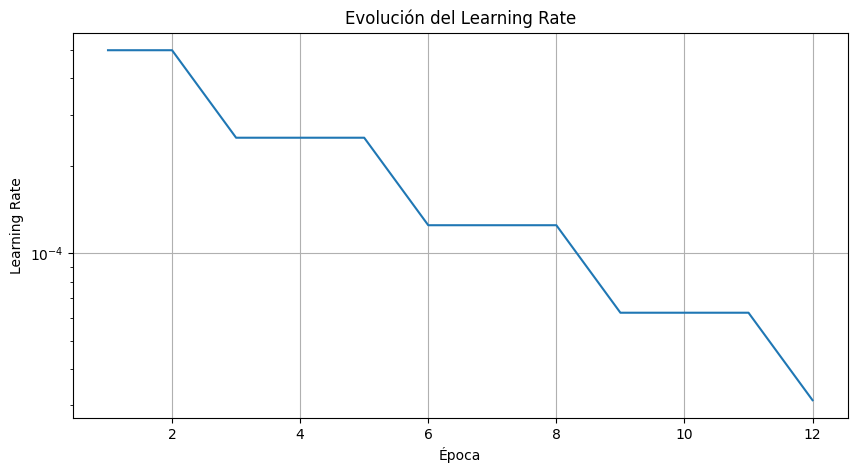

In [48]:
# Entrenamiento 6 (con dropout_rate=0.5, ELU, y hidden_dim=128)
SEED = 42
batch_size= 256
learning_rate = 5e-4
weight_decay = 1e-3
num_epochs = 20
early_stopping = 5

model, metrics, best_model_state, best_val_acc = POI_train_model(model, train_loader, val_loader, criterion,
                                     weight_decay, learning_rate, num_epochs, early_stopping,scheduler=None)

## **4. Evaluación y Análisis del Modelo**

In [49]:
# Guardamos el mejor modelo obtenido con búsqueda manual
# de los mejores hiperparámetros (entrenamiento 6)
torch.save(best_model_state, "mejor_modelo_POI.pt")
print("[INFO] Modelo guardado como mejor_modelo_POI.pt")

[INFO] Modelo guardado como mejor_modelo_POI.pt


In [54]:
# Cargar el mejor modelo guardado
model.load_state_dict(torch.load("mejor_modelo_POI.pt"))
model.to(device)
model.eval()

# Evaluamos en test
test_acc, all_preds, all_labels = evaluate_model(model, test_loader, device)
train_losses, val_losses, train_accs, val_accs = metrics
print(f"Accuracy en test: {test_acc:.3f}%")

print(classification_report(all_labels, all_preds, digits=3))

Accuracy en test: 87.288%
              precision    recall  f1-score   support

           0      0.855     0.946     0.898       112
           1      0.879     0.785     0.829        65
           2      0.907     0.831     0.867        59

    accuracy                          0.873       236
   macro avg      0.881     0.854     0.865       236
weighted avg      0.875     0.873     0.872       236



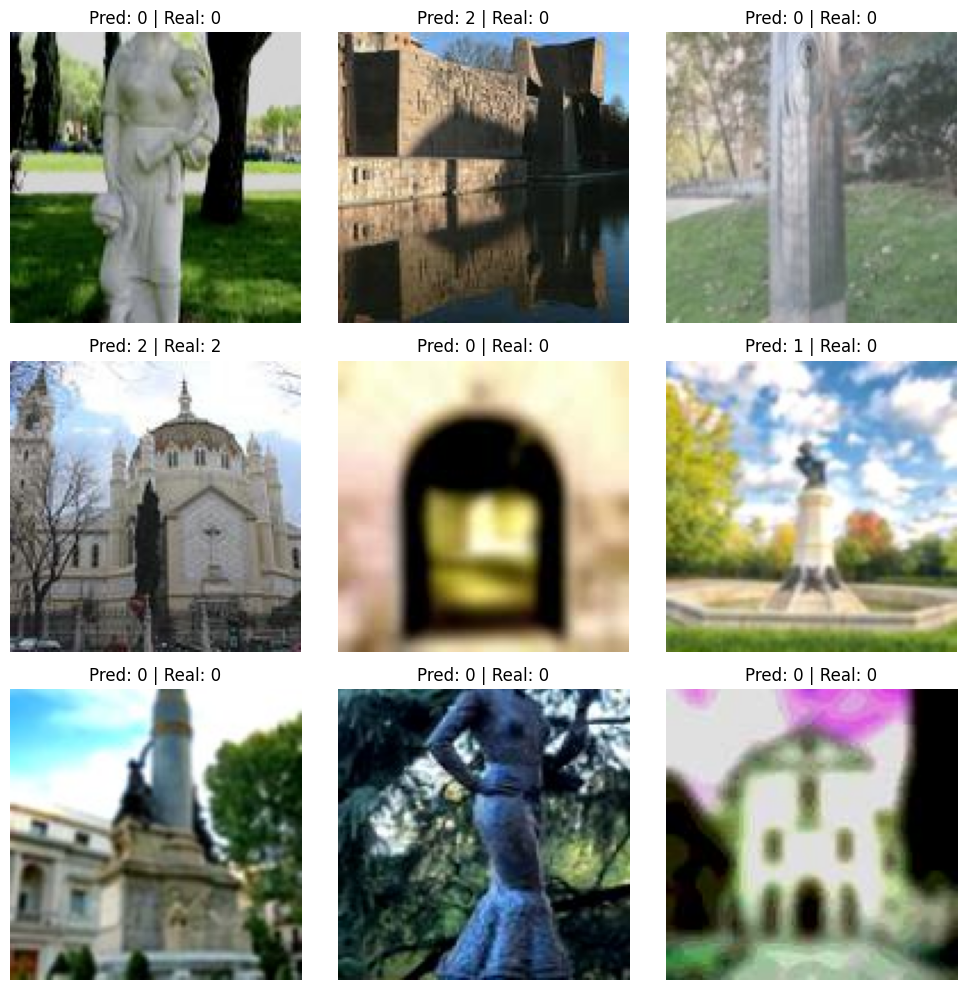

In [56]:
# Mostrar varias predicciones con sus imágenes
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    img = Image.open(img_paths_test[i]).convert("RGB")
    img_tensor = val_test_transform(img).unsqueeze(0).to(device)
    metadata_tensor = torch.tensor(X_test[i], dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor, metadata_tensor)
        pred_class = output.argmax(dim=1).item()

    ax.imshow(img)
    ax.set_title(f"Pred: {pred_class} | Real: {y_test[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()